In [310]:
import ast
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from tueplots import bundles
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tueplots.constants.color import rgb#

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 700})

In [339]:
# Read dataset
df = pd.read_csv('./Data/dataset.csv')

# Fix data types of some columns
df['cuisine_tags'] = df['cuisine_tags'].apply(ast.literal_eval)
df['nutrition'] = df['nutrition'].apply(lambda x: [float(value) for value in x.strip('[]').split(',')])

# Remove outliers
df = df[df['minutes'] <= 180]

# Drop useless columns
columns_to_drop = ['recipe_name', 'recipe_id', 'submission_date', 'ingredients', 'rating_dates']
df.drop(columns=columns_to_drop, inplace=True)

In [351]:
# Read json files containing cuisines tags
with open('./Data/cuisine_tags.json') as json_file:
    cuisine_tags = json.load(json_file)

# Read json files containing continents
with open('./Data/continents.json') as json_file:
    continents = json.load(json_file)

In [254]:
# Function select rows of df with a specific cuisine type
def filter_by_cuisine(row, cuisine):
    return any(tag in cuisine_tags[cuisine] for tag in row)

In [255]:
cuisines = []
n_recipes = []
n_vegan_recipes = []
n_vegetarian_recipes = []
avg_n_steps = []
avg_minutes = []
avg_n_ingredients = []
avg_calories = []
avg_total_fat = []
avg_sugar = []
avg_sodium = []
avg_protein = []
avg_carbohydrates = []

for cuisine in tqdm(cuisine_tags.keys()):
    cuisine_df = df[df['cuisine_tags'].apply(lambda row: filter_by_cuisine(row, cuisine))].copy(deep=True)
    cuisine_df.drop(columns=['cuisine_tags'], inplace=True)
    
    cuisines.append(cuisine)
    n_recipes.append(cuisine_df.shape[0])
    n_vegan_recipes.append(len(cuisine_df[cuisine_df['vegan']]))
    n_vegetarian_recipes.append(len(cuisine_df[(cuisine_df['vegetarian'] == True) & (cuisine_df['vegan'] == False)]))
    avg_n_steps.append(cuisine_df['n_steps'].mean())
    avg_minutes.append(cuisine_df['minutes'].mean())
    avg_n_ingredients.append(cuisine_df['n_ingredients'].mean())
    avg_calories.append(cuisine_df['nutrition'].apply(lambda x: x[0]).mean())
    avg_total_fat.append(cuisine_df['nutrition'].apply(lambda x: x[1]).mean())
    avg_sugar.append(cuisine_df['nutrition'].apply(lambda x: x[2]).mean())
    avg_sodium.append(cuisine_df['nutrition'].apply(lambda x: x[3]).mean())
    avg_protein.append(cuisine_df['nutrition'].apply(lambda x: x[4]).mean())
    avg_carbohydrates.append(cuisine_df['nutrition'].apply(lambda x: x[6]).mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 29.81it/s]


In [256]:
cuisine_stats = pd.DataFrame({
    'cuisine': cuisines,
    'n_recipes': n_recipes,
    'n_vegan_recipes': n_vegan_recipes,
    'n_vegetarian_recipes': n_vegetarian_recipes,
    'avg_n_steps': avg_n_steps,
    'avg_minutes': avg_minutes,
    'avg_n_ingredients': avg_n_ingredients,
    'avg_calories': avg_calories,
    'avg_total_fat': avg_total_fat,
    'avg_sugar': avg_sugar,
    'avg_sodium': avg_sodium,
    'avg_protein': avg_protein,
    'avg_carbohydrates': avg_carbohydrates,
})

cuisine_stats.to_csv('./Data/cuisine_stats.csv', index=False)

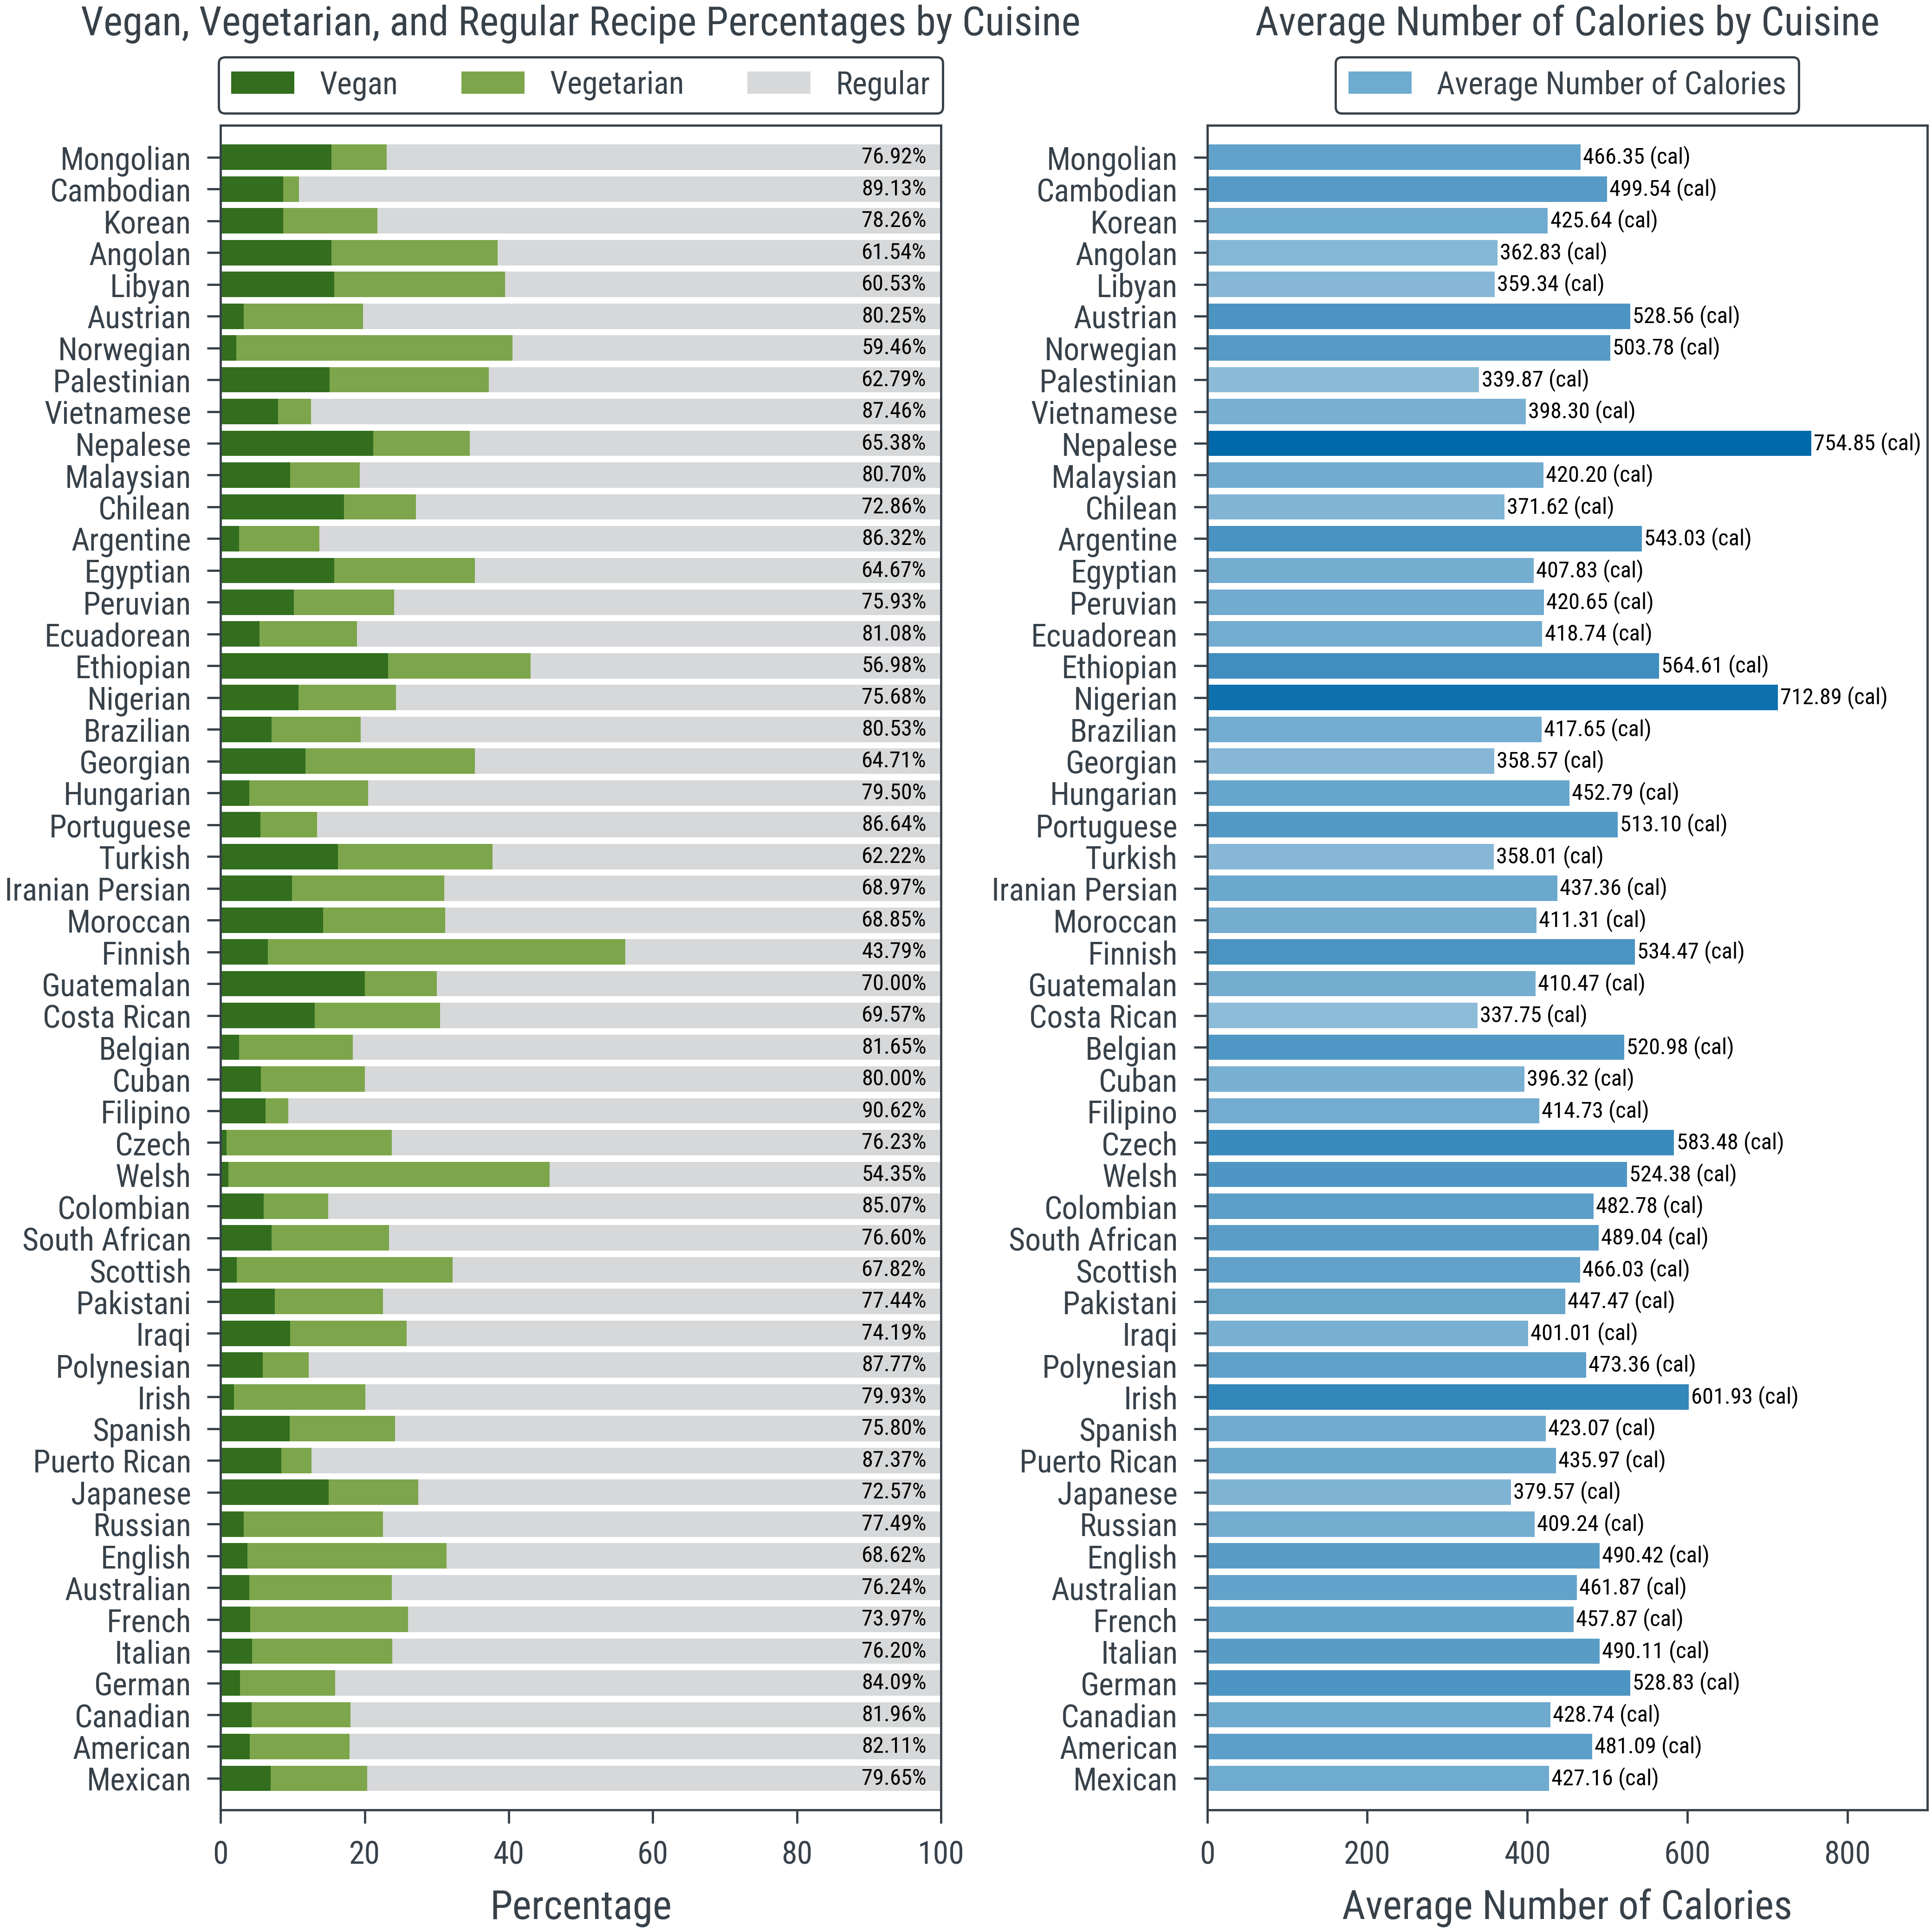

In [366]:
fig, axs = plt.subplots(1, 2, figsize=(6, 6))

# Plot 1: Vegan, Vegetarian, and Regular Recipe Percentages by Cuisine
axs[0].barh(cuisines, vegan_percentages, color=rgb.tue_darkgreen, label='Vegan')
axs[0].barh(cuisines, vegetarian_percentages, left=vegan_percentages, color=rgb.tue_green, label='Vegetarian')
bars = axs[0].barh(cuisines, regular_percentages, left=vegan_percentages+vegetarian_percentages, color=rgb.tue_gray, alpha=0.5, label='Regular')

for bar, percentage in zip(bars, regular_percentages):
    axs[0].text(bar.get_x() + bar.get_width() - 2, bar.get_y() + bar.get_height() / 2, f'{percentage:.2f}%', ha='right', va='center', color='black', fontsize=5)

axs[0].set_xlim([0, 100])
axs[0].set_ylim(-1, len(cuisines))
axs[0].set_xlabel('Percentage')
axs[0].set_title('Vegan, Vegetarian, and Regular Recipe Percentages by Cuisine', pad=20)
axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, framealpha=1, facecolor="white", frameon=True)

# Plot 2: Average Number of Calories by Cuisine
avg_calories = np.array(avg_calories)
alphas = avg_calories / max(avg_calories)

bars = axs[1].barh(cuisines, avg_calories, color=rgb.tue_blue, label='Average Number of Calories')
for bar, alpha, avg_calories_text in zip(bars, alphas, avg_calories):
    bar.set_alpha(alpha)
    axs[1].text(bar.get_width() + 3, bar.get_y() + bar.get_height() / 2, f'{avg_calories_text:.2f} (cal)', ha='left', va='center', color='black', fontsize=5)

axs[1].set_xlim([0, 900])
axs[1].set_ylim(-1, len(cuisines))
axs[1].set_xlabel('Average Number of Calories')
axs[1].set_title('Average Number of Calories by Cuisine', pad=20)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, framealpha=1, facecolor="white", frameon=True)

plt.show()

fig.savefig('./visuals/recipe_type_and_n_calories_per_cuisine.png')

In [369]:
continent_colors = {
    'European': rgb.tue_darkblue,
    'African': rgb.tue_green,
    'Asian': rgb.tue_red,
    'Oceanian': rgb.tue_gray,
    'North American': rgb.tue_lightblue,
    'South American': rgb.pn_orange,
}

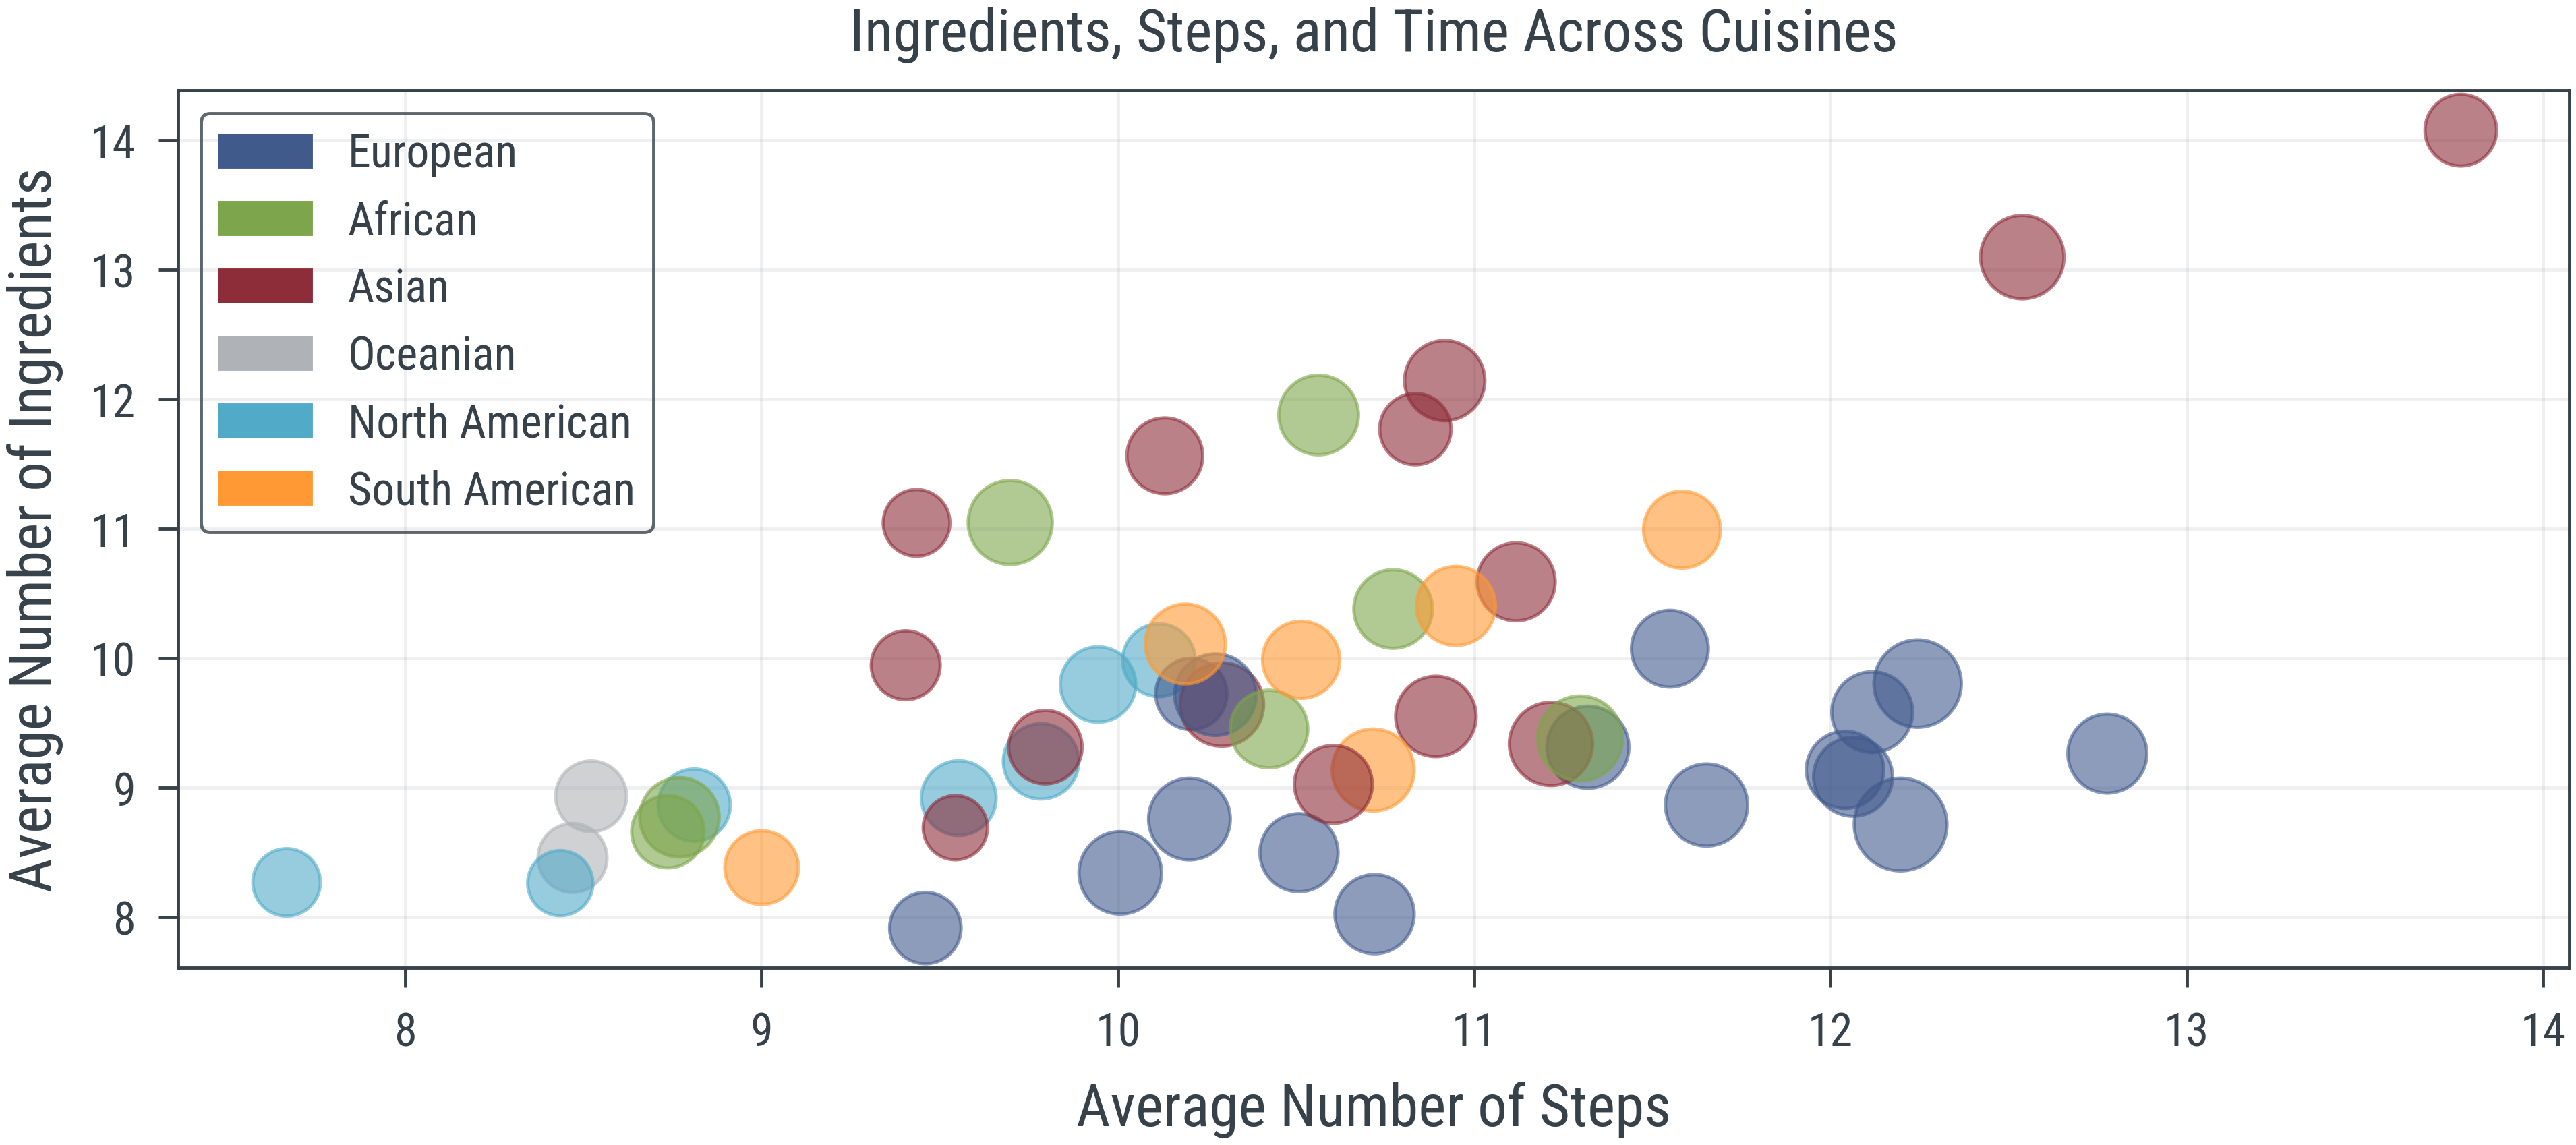

In [370]:
fig, ax = plt.subplots()

sizes = avg_minutes / max(avg_minutes) * 200
colors = [continent_colors[continents[cuisine]] for cuisine in cuisines]

ax.scatter(avg_n_steps, avg_n_ingredients, s=sizes, color=colors, alpha=0.6)

ax.set_xlabel('Average Number of Steps')
ax.set_ylabel('Average Number of Ingredients')

ax.grid(axis="x", which="major", color=rgb.tue_gray, linewidth=0.5)
ax.grid(axis="y", which="major", color=rgb.tue_gray, linewidth=0.5)

handles = [Patch(color=color, label=continent) for continent, color in continent_colors.items()]
ax.legend(handles=handles, loc='upper left')

ax.set_title('Ingredients, Steps, and Time Across Cuisines')

plt.show()

fig.savefig('./visuals/n_ingredients_steps_minutes_per_cuisine.png')